# Приложение Procrastinate Pro+

## Описание проекта
<br>Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.
<br><br>
У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

## Шаг 1. Загрузите данные и подготовьте их к анализу

Импортируем библиотеки:

In [47]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

Прочитаем файлы `/datasets/visits_info_short.csv`, `/datasets/orders_info_short.csv` и `/datasets/costs_info_short.csv` и сохраним его в переменную соответственно `df_visit`, `df_order` и `df_cost`. 
<br>Для того что бы не получать ошибки при загрузке файла, то локально, то с сервера, используем следующий код:

In [48]:
import os

pth1 = '/datasets/visits_info_short.csv'
pth2 = './visits_info_short.csv'
pth3 = '/datasets/orders_info_short.csv'
pth4 = './orders_info_short.csv'
pth5 = '/datasets/costs_info_short.csv'
pth6 = './costs_info_short.csv'

if os.path.exists(pth1):
    df_visit = pd.read_csv(pth1)    
elif os.path.exists(pth2):
    df_visit = pd.read_csv(pth2)
else:
    print("Проверьте правильность пути к датасету")

if os.path.exists(pth3):
    df_order = pd.read_csv(pth3)    
elif os.path.exists(pth4):
    df_order = pd.read_csv(pth4)
else:
    print("Проверьте правильность пути к датасету")
    
if os.path.exists(pth5):
    df_cost = pd.read_csv(pth5)    
elif os.path.exists(pth6):
    df_cost = pd.read_csv(pth6)
else:
    print("Проверьте правильность пути к датасету")


Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный.

In [49]:
display(df_visit.info())
display(df_order.info())
df_cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


#### Описание данных
Таблица visits_log_short или df_visit (лог сервера с информацией о посещениях сайта):
<br>
<br>`User Id` — уникальный идентификатор пользователя
<br>`Device` — категория устройства пользователя
<br>`Session start` — дата и время начала сессии
<br>`Session End` — дата и время окончания сессии
<br>`Channel` — идентификатор рекламного источника, из которого пришел пользователь
<br>`Region` - страна пользователя
<br><br>
Таблица orders_log_short или df_order (информация о заказах):
<br>
<br>`User Id` — уникальный id пользователя, который сделал заказ
<br>`Event Dt` — дата и время покупки
<br>`Revenue` — выручка
<br><br>
Таблица costs_short или df_cost (информация о затратах на маркетинг):
<br>
<br>`Channel` — идентификатор рекламного источника
<br>`Dt` — дата
<br>`Costs` — затраты на этот рекламный источник в этот день

Во всех датафреймах отсутсвуют пропущенные значения, однако названия столбцов нужно привезти к "змеиному регистру", а также столбцы содержащие дату необходимо перевести в формат `datetime`

In [50]:
#приведение заголовков к змеиному регистру:
df_visit.columns = df_visit.columns.str.lower().str.replace(' ', '_')
df_order.columns = df_order.columns.str.lower().str.replace(' ', '_')
df_cost.columns = df_cost.columns.str.lower().str.replace(' ', '_')

In [51]:
#преобразуем формат данных 
df_visit['session_start'] = pd.to_datetime(df_visit['session_start'])
df_visit['session_end'] = pd.to_datetime(df_visit['session_end'])
df_order['event_dt'] = pd.to_datetime(df_order['event_dt'])
df_cost['dt'] = pd.to_datetime(df_cost['dt']).dt.date

In [52]:
#проверка на наличие явных дубликатов
df_visit.duplicated().sum()
df_order.duplicated().sum()
df_cost.duplicated().sum()

0

Создадим функицию, позволяющую проводить первичный анализ исходных данных:

In [53]:
def info(data):
    print('Первые 5 строк:')
    display(data.head())
    print('информация:')
    display(data.info())
    print('общие параметры:')
    print(data.describe())
    print(data.columns)
    print('Пропущенные значения:')
    print(data.isna().sum())
    display(pd.DataFrame(round((data.isna().mean()*100),2),columns=['NaNs,%']).style.format('{:.2f}'))

In [54]:
info(df_visit)

Первые 5 строк:


,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


None

общие параметры:
            user_id
count  3.099010e+05
mean   4.997664e+11
std    2.887899e+11
min    5.993260e+05
25%    2.493691e+11
50%    4.989906e+11
75%    7.495211e+11
max    9.999996e+11
Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')
Пропущенные значения:
user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64


,"NaNs,%"
user_id,0.00
region,0.00
device,0.00
channel,0.00
session_start,0.00
session_end,0.00


In [55]:
info(df_order)

Первые 5 строк:


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


None

общие параметры:
            user_id       revenue
count  4.021200e+04  40212.000000
mean   4.990295e+11      5.370608
std    2.860937e+11      3.454208
min    5.993260e+05      4.990000
25%    2.511324e+11      4.990000
50%    4.982840e+11      4.990000
75%    7.433327e+11      4.990000
max    9.998954e+11     49.990000
Index(['user_id', 'event_dt', 'revenue'], dtype='object')
Пропущенные значения:
user_id     0
event_dt    0
revenue     0
dtype: int64


,"NaNs,%"
user_id,0.00
event_dt,0.00
revenue,0.00


In [56]:
info(df_cost)

Первые 5 строк:


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

общие параметры:
             costs
count  1800.000000
mean     58.609611
std     107.740223
min       0.800000
25%       6.495000
50%      12.285000
75%      33.600000
max     630.000000
Index(['dt', 'channel', 'costs'], dtype='object')
Пропущенные значения:
dt         0
channel    0
costs      0
dtype: int64


,"NaNs,%"
dt,0.00
channel,0.00
costs,0.00


<div class="alert alert-info"> <b></b>Проверим соответствует ли временным условиям предоставленные данные. Согласно условию данные должны быть представлены на период с 1 мая по 27 октября 2019 года: </div>

In [57]:
first_date_min = df_visit['session_start'].dt.date.min()
first_date_max = df_visit['session_start'].dt.date.max()
delta_first_date = first_date_max - first_date_min
print(f"Mинимальная дата привлечения пользователей:{first_date_min}")
print(f"Максимальная дата привлечения пользователей:{first_date_max}")
print(f"Диапазон дней, в которые привлекались пользователи:{delta_first_date}")

Mинимальная дата привлечения пользователей:2019-05-01
Максимальная дата привлечения пользователей:2019-10-31
Диапазон дней, в которые привлекались пользователи:183 days, 0:00:00


### Вывод
На данном этапе были загружены необходимые бибилиотеки, преобразованы типы данных и изучена информация инходных данных.
В исходных данных отсутсвуют пропущенные значения и дубликаты. Данные соответствуют условию по временному интервалу, также отсутсвуют отрицательные значения или нули.<br>Соответствуенно данные качественные и могут быть использованы для дальнейшего анализа.

## Шаг 2. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

In [58]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    
    return profiles


In [59]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [60]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [61]:
 #функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

А также функции для визуализации этих метрик — `filter_data()`, `plot_retention()`, `plot_conversion()` и `plot_ltv_roi()`:

In [62]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [63]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [64]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [65]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Вывод
На данном этапе были добавлены функции, изученные в курсе до этого для расчета, анализа и визуализации.

## Шаг 3. Проведите исследовательский анализ данных

Постройте профили пользователей. Используем функцию из шага 2: `get_profiles`.

In [66]:
# получаем профили пользователей
profiles = get_profiles(df_visit, df_order, df_cost)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


В таблице `profiles` содержится информация:
<br>
<br>`user_id` — уникальный идентификатор пользователя
<br>`first_ts` — дата и время начала сессии
<br>`channel` — идентификатор рекламного источника, из которого пришел пользователь
<br>`device` — категория устройства пользователя
<br>`region` - страна пользователя
<br>`dt` — дата первого посещения
<br>`month` — первый день месяца, в который первое посещение произошло
<br>`payer` — признак платящих пользователей
<br>`acquisition_cost` — затраты на рекламу для привлечение уникального пользователя
<br>`revenue` — выручка за покупку

Минимальную и максимальную дату привлечения пользователей находили на 1 шаге, продублируем результат:

In [67]:
print(f"Mинимальная дата привлечения пользователей:{first_date_min}")
print(f"Максимальная дата привлечения пользователей:{first_date_max}")
print(f"Диапазон дней, в которые привлекались пользователи:{delta_first_date}")

Mинимальная дата привлечения пользователей:2019-05-01
Максимальная дата привлечения пользователей:2019-10-31
Диапазон дней, в которые привлекались пользователи:183 days, 0:00:00


Зададим горизонт анализа данных равный двум неделям.

In [68]:
observation_date = datetime(2019, 10, 1).date()
horizon_days = 14
last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
print(f"Mаксимальная дата привлечения пользователей:{last_suitable_acquisition_date}")

Mаксимальная дата привлечения пользователей:2019-09-18


Рассмотрим из каких стран приходят посетители и какие страны дают больше всего платящих пользователей:

In [69]:
profiles.groupby('region').agg({'user_id': 'nunique','payer': 'mean'}).rename(
    columns={'payer': 'доля платящих', 'user_id': 'кол-во пользователей'}).sort_values(
    by='доля платящих', ascending=False).style.format({'доля платящих': '{:.2%}'})

,кол-во пользователей,доля платящих
region,,
United States,100002,6.90%
Germany,14981,4.11%
UK,17575,3.98%
France,17450,3.80%


Первое место занимаеют США по привлечению пользователей в приложение Procrastinate Pro+, а также по числу платящих пользователей.

Теперь рассмотрим какими устройствами они пользуются и с каких устройств чаще всего заходят платящие пользователи:

In [70]:
profiles.groupby('device').agg({'user_id': 'nunique','payer': 'mean'}).rename(
    columns={'payer': 'доля платящих', 'user_id': 'кол-во пользователей'}).sort_values(
    by='доля платящих', ascending=False).style.format({'доля платящих': '{:.2%}'})

,кол-во пользователей,доля платящих
device,,
Mac,30042,6.36%
iPhone,54479,6.21%
Android,35032,5.85%
PC,30455,5.05%


Платящие пользователи чаще используют: Mac и iPhone, но разрыв с Android небольшой.

Рассмотрим по каким рекламным каналам шло привлечение пользователей и какие каналы приносят больше всего платящих пользователей:

In [71]:
profiles.groupby('channel').agg({'user_id': 'nunique','payer': 'mean'}).rename(
    columns={'payer': 'доля платящих', 'user_id': 'кол-во пользователей'}).sort_values(
    by='доля платящих', ascending=False).style.format({'доля платящих': '{:.2%}'})

,кол-во пользователей,доля платящих
channel,,
FaceBoom,29144,12.20%
AdNonSense,3880,11.34%
lambdaMediaAds,2149,10.47%
TipTop,19561,9.60%
RocketSuperAds,4448,7.91%
WahooNetBanner,8553,5.30%
YRabbit,4312,3.83%
MediaTornado,4364,3.57%
LeapBob,8553,3.06%


Большинство пользователей пришли через приложение FaceBoom.

### Вывод
Мы смогли составить портрет платящего пользователя: с большой долей вероятности он проживает в США, использует Mac или iPhone и активно пользуется FaceBoom.

## Шаг 4. Маркетинг

Изучим сколько денег потратили пользователи всего, сколько денег принес каждый источник рекламы и за какое время (за какой месяц было получено больше всего денег).

In [72]:
#добавляем вырочку за заказ
profiles1 = profiles.merge(df_order,on=['user_id'],how='left')

# вырочку за заказ неплатящих пользователей равна нулю
profiles1['revenue'] = profiles1['revenue'].fillna(0)

In [73]:
print('Всего пользователи потратили за 179 дней:',profiles1['revenue'].sum().astype('int'),'у.е.')

Всего пользователи потратили за 179 дней: 215962 у.е.


In [74]:
profiles1.groupby('channel').agg({'revenue': 'sum'}).rename(
    columns={'revenue': 'сумма'}).sort_values(by='сумма', ascending=False).astype('int')

,сумма
channel,
TipTop,69574
organic,46627
FaceBoom,25637
WahooNetBanner,20006
RocketSuperAds,11598
LeapBob,9560
lambdaMediaAds,8941
OppleCreativeMedia,8365
YRabbit,6201


In [75]:
# Добавим столбец с номером месяца
profiles1['just_month'] = profiles1['month'].dt.month
profiles1.groupby('just_month').agg({'revenue': 'sum'}).rename(
    columns={'revenue': 'сумма'}).sort_values(by='сумма', ascending=False).astype('int')

,сумма
just_month,
5,49018
6,43447
7,38296
8,37238
9,30344
10,17617


Выясним, как меняется стоимость привлечения для каждого источника от когорты к когорте. Для этого построим сводную таблицу, в которой названиями строк будут даты привлечения пользователей, названиями столбцов — каналы привлечения, а значениями — средний CAC, и построим по ней график истории изменений.

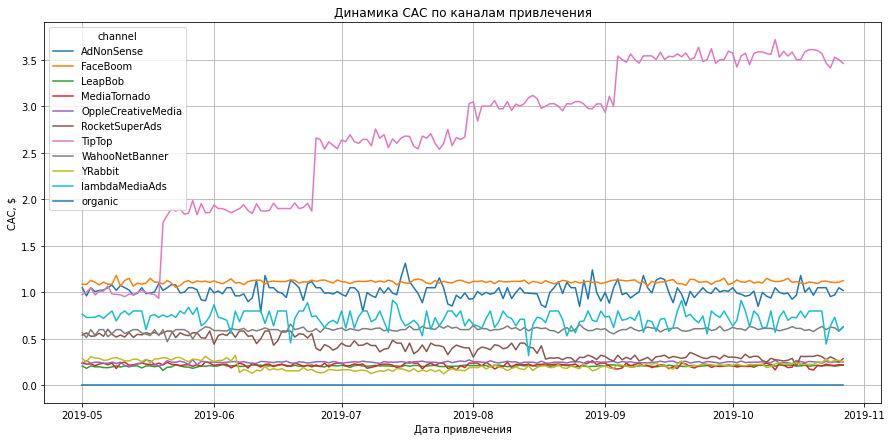

In [76]:
# строим график истории изменений CAC по каналам привлечения
profiles1.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 7))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

In [77]:
# Рассчитайте средний CAC на одного пользователя для каждого источника трафика
# рассчитываем LTV и ROI

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, df_order, observation_date, horizon_days, dimensions=['channel']
)

roi[['cohort_size','cac']].sort_values(by='cac', ascending=False)  # таблица ROI

,cohort_size,cac
channel,,
TipTop,14236,2.522043
FaceBoom,21243,1.113049
AdNonSense,3029,1.011869
lambdaMediaAds,1674,0.726882
WahooNetBanner,6182,0.600485
RocketSuperAds,3399,0.447293
OppleCreativeMedia,6205,0.249758
MediaTornado,3354,0.220680
YRabbit,3257,0.215784


Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [78]:
profiles1.groupby('channel').agg({'user_id': 'nunique','acquisition_cost': 'mean'}).rename(
    columns={'user_id': 'покупатель','acquisition_cost': 'среднее'}).sort_values(by='среднее', ascending=False)

,покупатель,среднее
channel,,
TipTop,19561,2.700062
FaceBoom,29144,1.113254
AdNonSense,3880,1.008149
lambdaMediaAds,2149,0.731293
WahooNetBanner,8553,0.600988
RocketSuperAds,4448,0.425830
OppleCreativeMedia,8605,0.250072
MediaTornado,4364,0.219090
YRabbit,4312,0.218692


In [79]:
# средний CAC на одного пользователя для всего проекта
roi['cac'].mean()

0.731757400286846

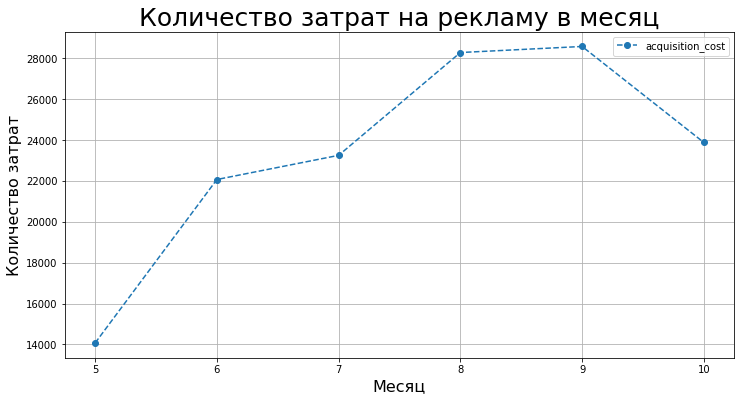

In [80]:
#Построим график количества затрат на рекламу в месяц
profiles1 = profiles1.query('channel != "organic"')
profiles1.pivot_table(index='just_month', values='acquisition_cost', aggfunc='sum').plot(
    style='o--', figsize=(12, 6), grid=True)

plt.xlabel('Месяц', fontsize=16)
plt.ylabel('Количество затрат', fontsize=16)
plt.title('Количество затрат на рекламу в месяц', fontsize=25);


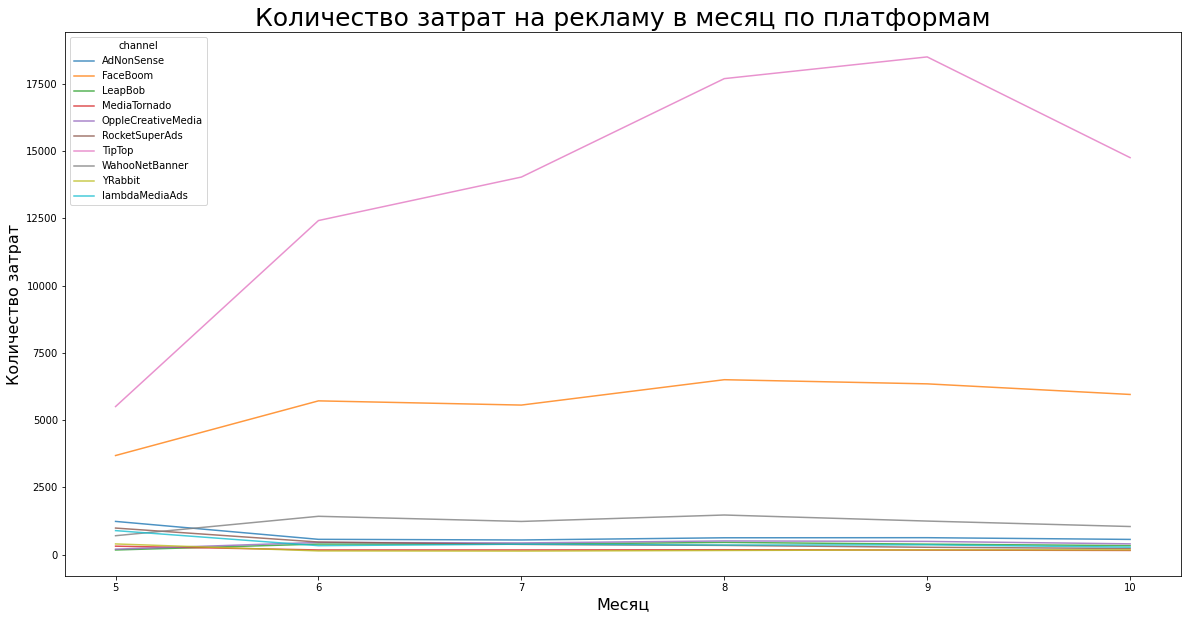

In [81]:
#Построим график количества затрат на рекламу в месяц для каждого источника

profiles1.pivot_table(index='just_month',columns='channel',
                   values='acquisition_cost',aggfunc='sum').plot(figsize=(20,10),alpha=0.8)

plt.xlabel('Месяц', fontsize=16)
plt.ylabel('Количество затрат', fontsize=16)
plt.title('Количество затрат на рекламу в месяц по платформам', fontsize=25);


### Вывод
Всего, за период исследования, пользователи потратили 215962 у.е. Больше всего денег заплатили пользователи, пришедшие через приложение TipTop. Май был самым успешным месяцем, далее выручка начала падать и за полгода упала на 36%. Средняя стоимость привлечения покупаделей облателей iPhone составляет 0,88 и самая низкая для пользователей РС 0,55. В среднем стоимость привлечения одно пользователя по всему проекту 0.731 у.е.

## Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. 

### Проанализируйте общую окупаемость рекламы

Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI, вызвав функции `get_ltv()` и `plot_ltv_roi()`:

In [82]:
profiles = profiles.query('channel != "organic"')

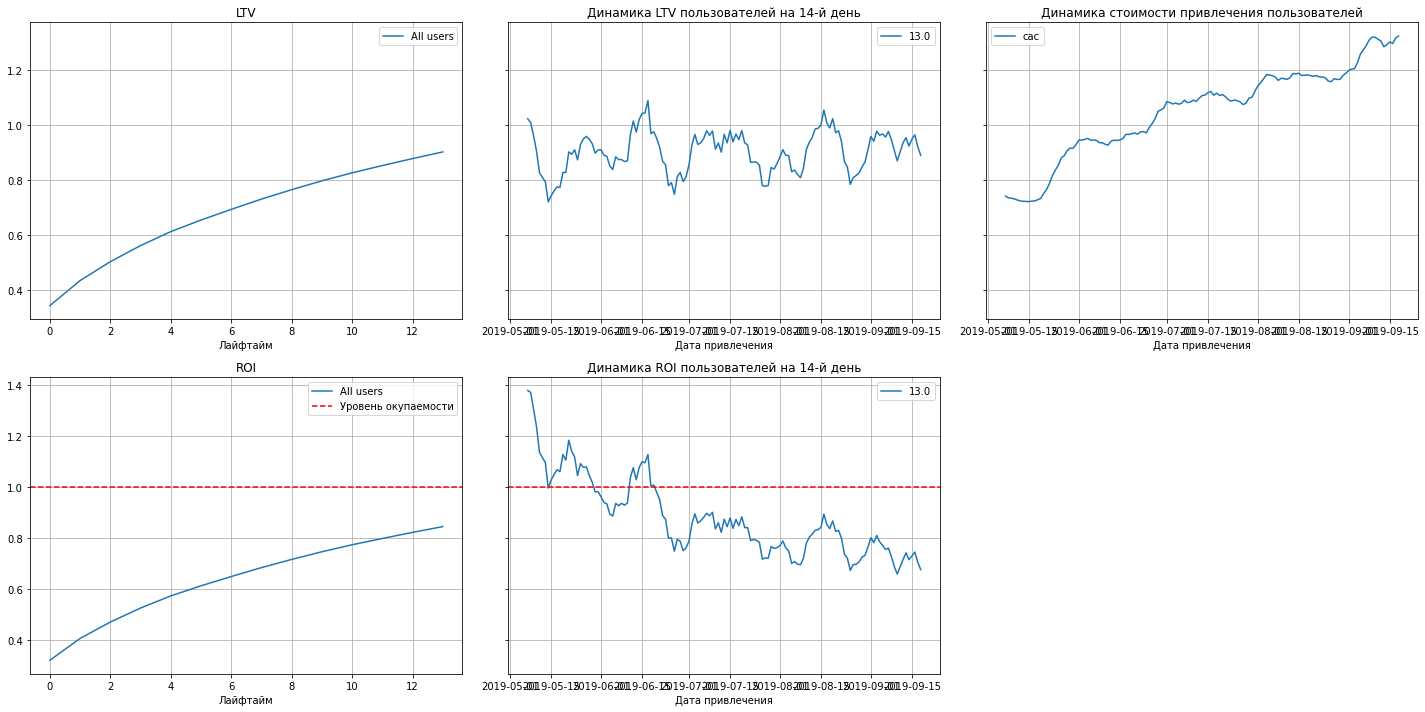

In [83]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_order, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
* Реклама окупается на 12 день. ROI в конце второй недели пересекает линию окупаемости.
* CAC возрастает. Значит, увеличивается рекламный бюджет.
* На LTV не влияет сезонный фактор, этот показатель достаточно стабилен. Не наблюдается ухудшение качества пользователей.
* Динамика ROI снижается за весь период рассмотрения.
<br>Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

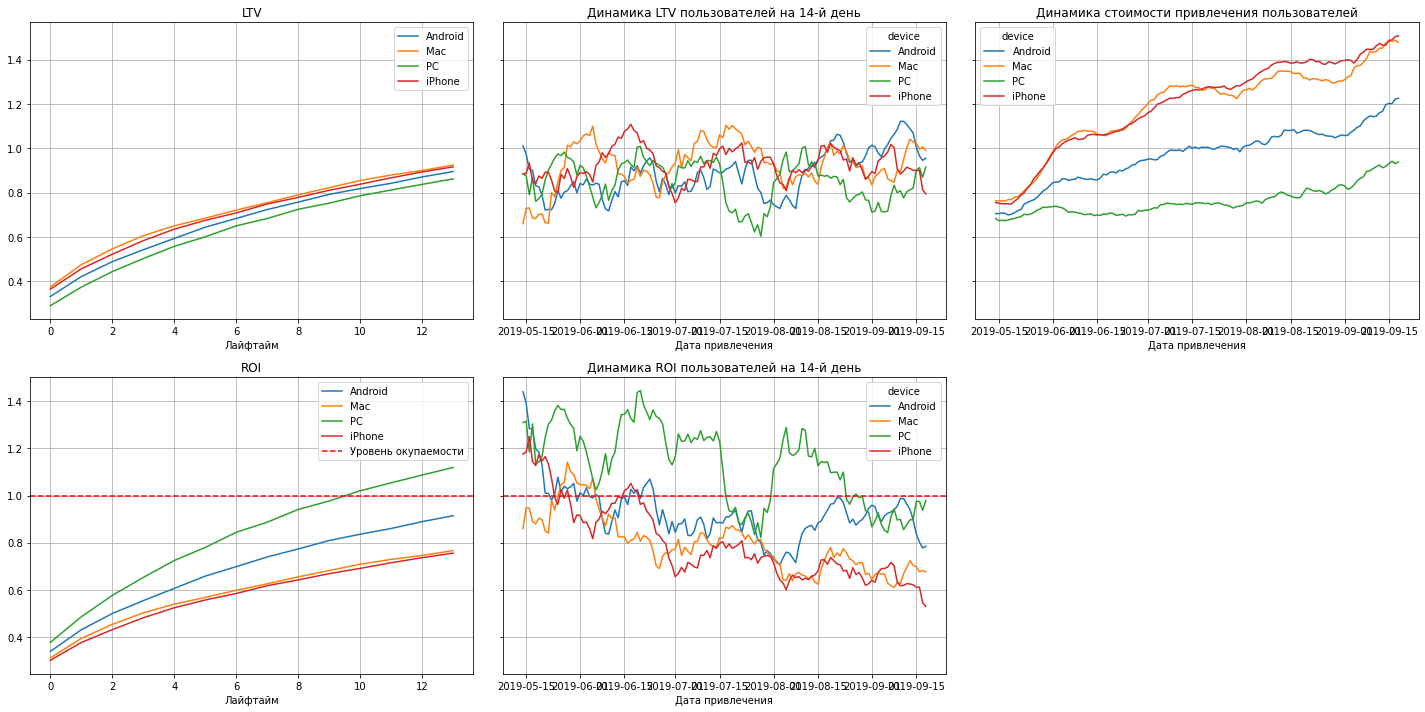

In [84]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_order, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

С разбивкой по устройствам вот что говорят графики:
* Реклама не окупается для "яблочных" пользователей, реклама для пользователей РС окупается в конце первой недели, также на 10 день окупается для пользователей Android.
* Стоимость привлечения возрастает для всех устройств, однако для "яблочных" пользователей больше всего.
* LTV всё так же подвержен сезонности, но стабилен.
<br>
Пользователи iPhone и Мас стабильно не окупаются. На это нужно обратить внимание.

### Проанализируйте окупаемость рекламы с разбивкой по странам

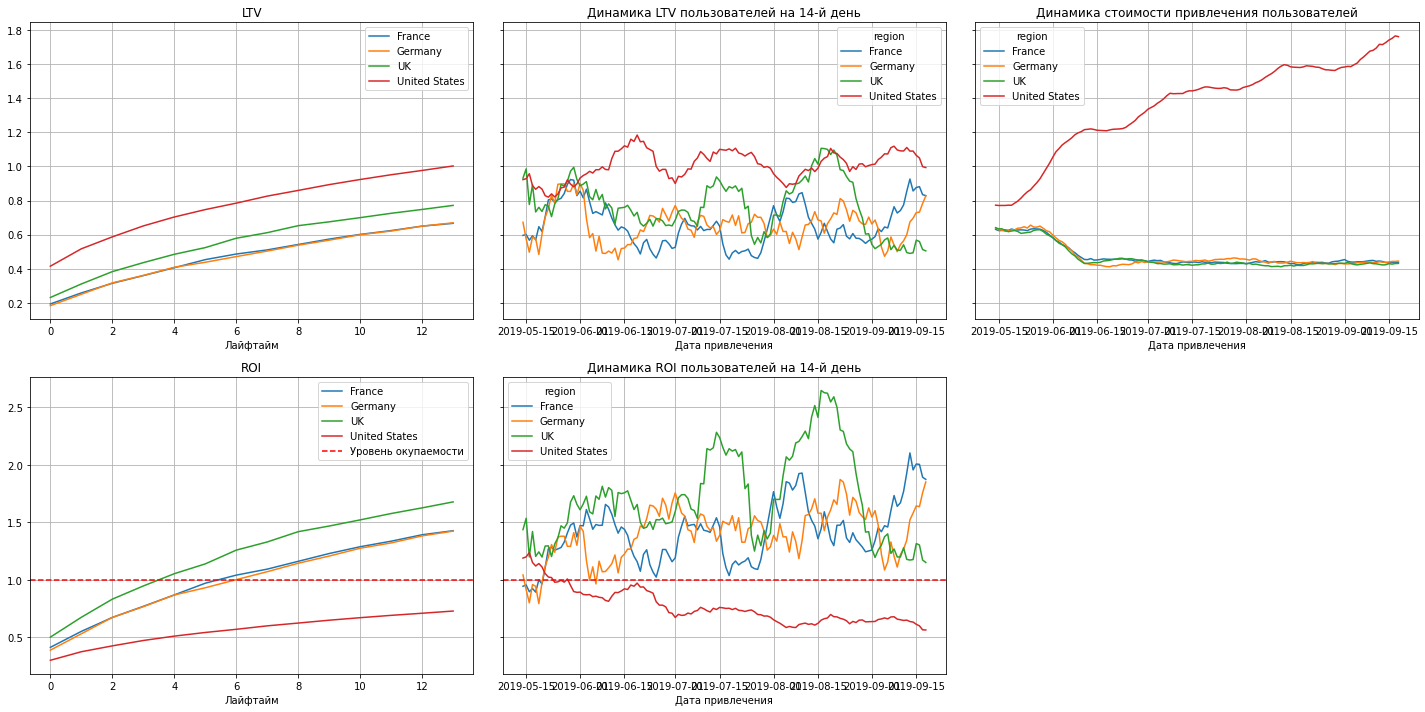

In [85]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_order, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 


С разбивкой по странам вот что говорят графики:
* Реклама не окупается для пользователей из США, реклама для других пользователей окупается в середине первой недели.
* Стоимость привлечения возрастает также для пользователей из США, для остальный стабильный уровень.
* LTV всё так же подвержен сезонности, но стабилен.
<br>
Пользователи из США стабильно не окупаются. На это нужно обратить внимание.

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

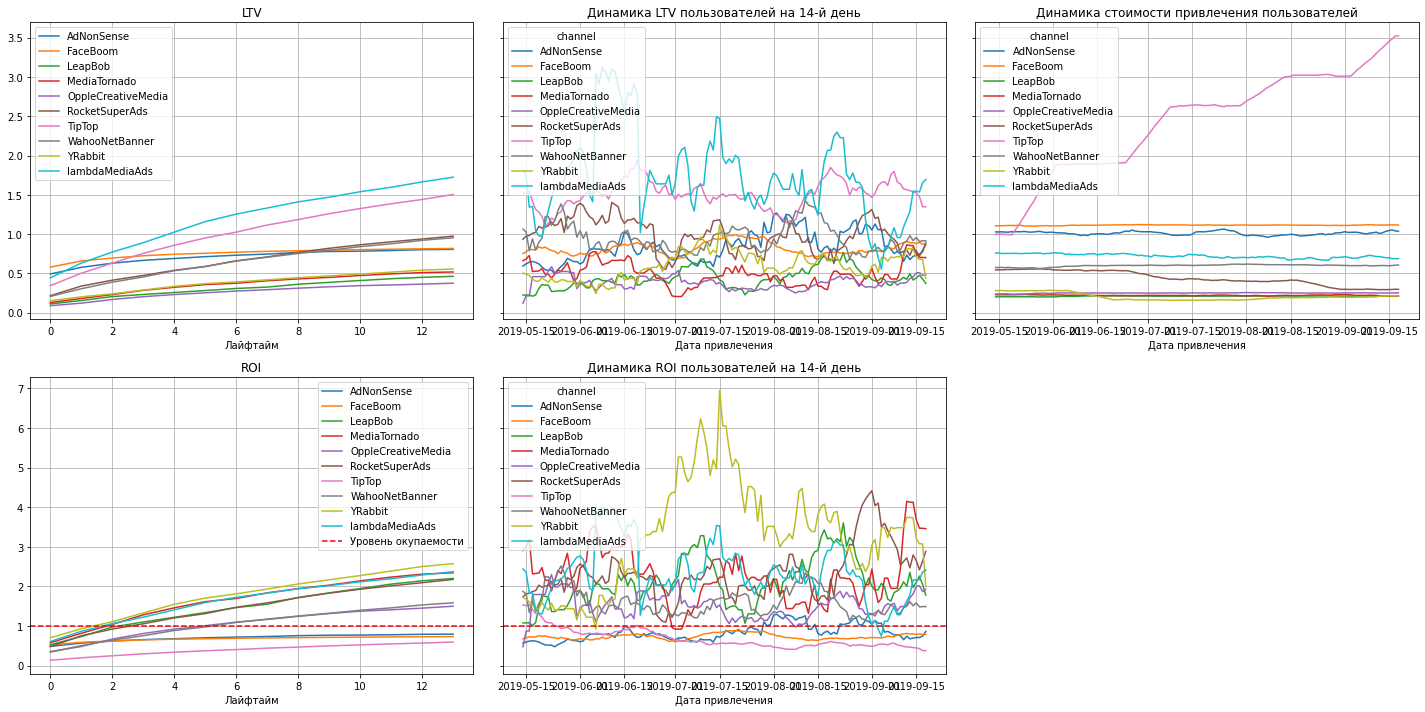

In [86]:
# смотрим окупаемость с разбивкой по рекламным каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_order, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

С разбивкой по источникам привлечения вот что говорят графики:
* Реклама не окупается для пользователей пришедших через TipTop, FacaBoom и AdNonSense, реклама для других пользователей окупается в течение первой недели.
* Стоимость привлечения возрастает только для пользователей TipTop, по остальным источникам стабильный уровень.
* LTV всё так же подвержен сезонности, но стабилен. Качество пользователей стабильно.
<br>
Пользователи TipTop, FacaBoom и AdNonSense стабильно не окупаются, однако в TipTop постоянно возрастает стоимость привлечения денежных средств в рекламу. На это нужно обратить внимание.

Для платформы YRabbit при некотором снижении стоимости привлечения пользователей наблюдается повышение окупаемости инвестиций. Для платформы TipTop при значительных увеличениях затрат на привлечение пользователей напротив снижается окупаемость. Стоит обратить внимание на пользователей lambdaMediaAds стабильный высокий уровень LTV, наблюдается незначительное снижение стоимость привлечения денежных средств при этом хороший уровень окупаемости (достаточно высокий среду аналогичных источников).


### Проанализируйте конверсию и удержание

Посчитаем и визуализируем конверсию, вызвав функции `get_conversion()` и `plot_conversion()`.
<br> Рассмотрим конверсию с разбивкой по устройствам:

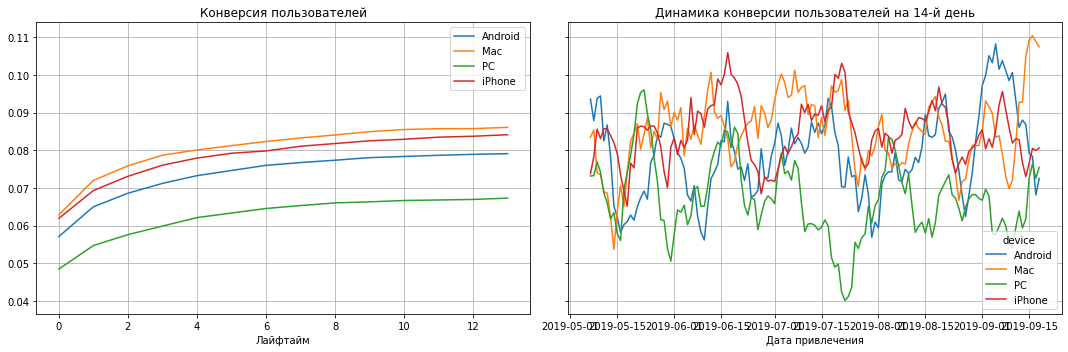

In [87]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, df_order, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Рассмотрим удержание с разбивкой по устройствам:

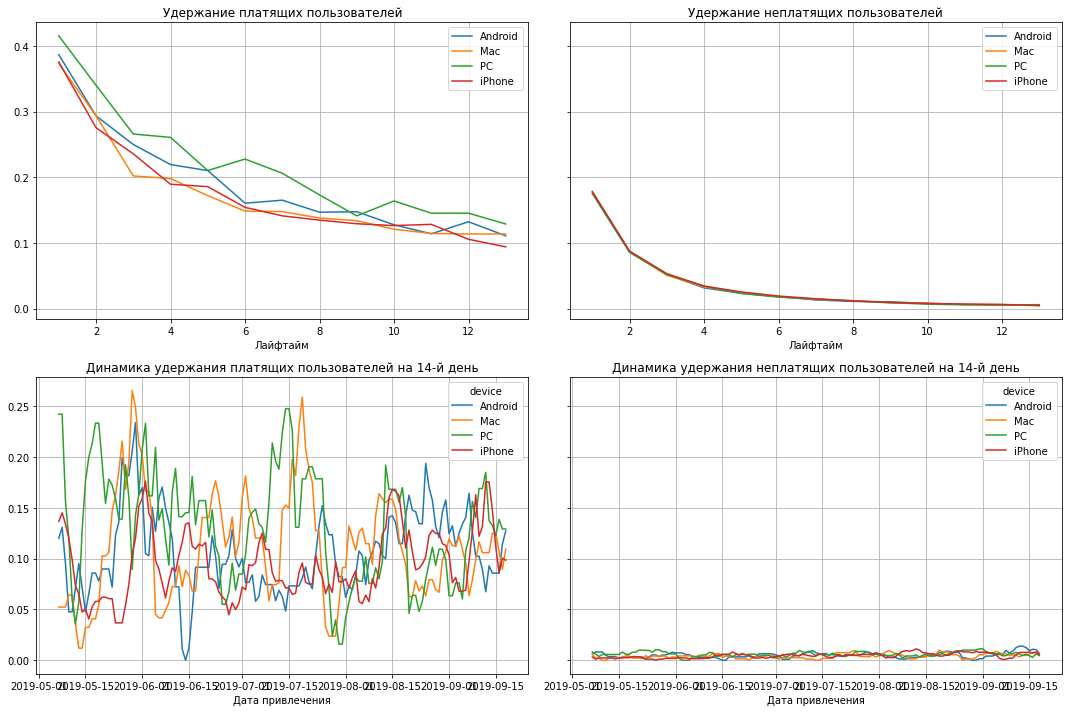

In [88]:
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, df_visit, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Судя по графикам, все пользователи конвертируются хорошо, однако пользователи PC хуже других. Удержание у всех пользователей стабильно не очень хорошее.

Рассмотрим конверсию с разбивкой по странам:

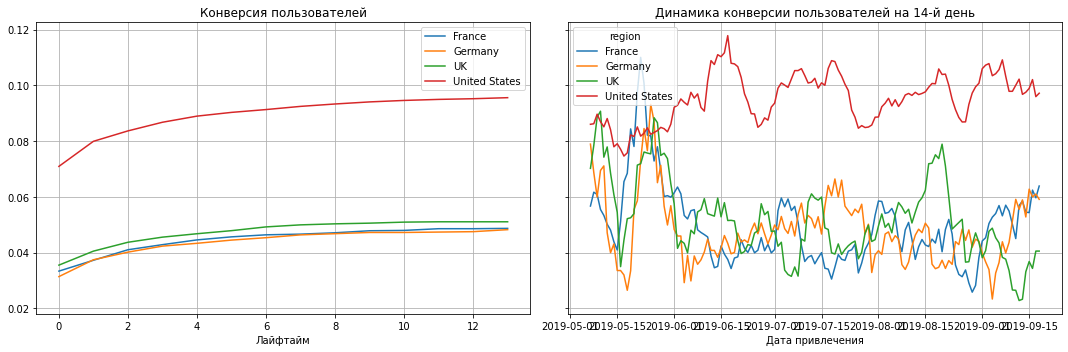

In [89]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, df_order, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Рассмотрим удержание с разбивкой по странам:

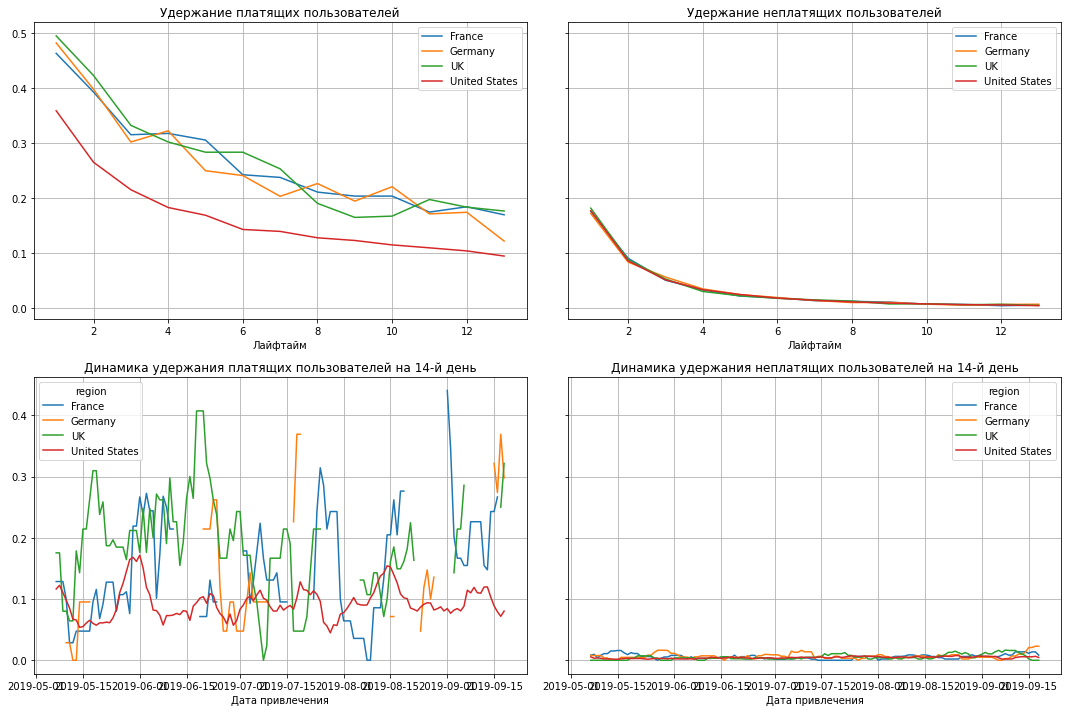

In [90]:
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, df_visit, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Судя по графикам лучше всего конверсия у пользователей из США.
Однако пользователи из США стабильно удерживаются хуже других. 
При этом у всех пользователей низкий уровень удержания около 20%. Это мало!

Рассмотрим конверсию с разбивкой по рекламным каналам:

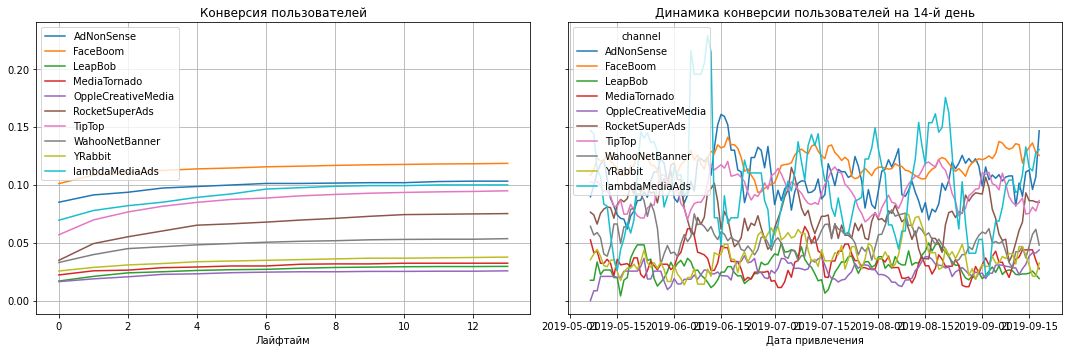

In [91]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, df_order, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Рассмотрим удержание с разбивкой по рекламным каналам:

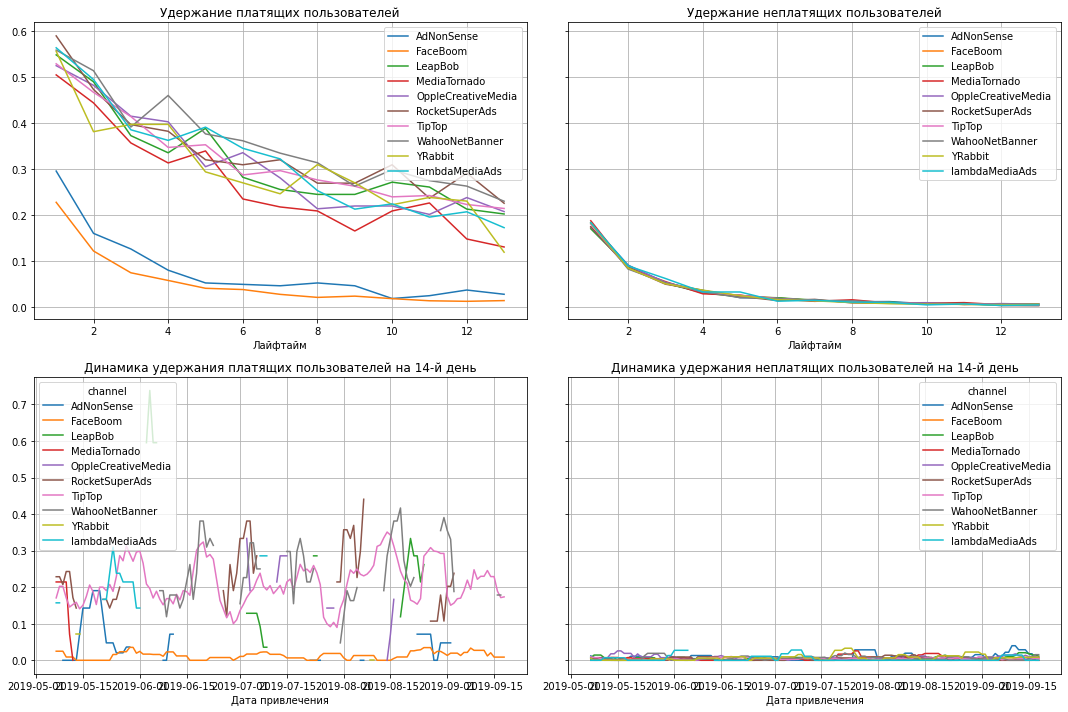

In [92]:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, df_visit, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Конверсия всех рекламных каналов достаточно низкая, но выше всех у FaceBoom. Удержание в целом низкое, но стабильное. Выбиваются в отрицательную стороны два источника: FaceBoom и AdNonSense. У FaceBoom стабильно низкая динамика удержания пользователей.

Проблемы с окупаемостью могут быть вызваны низким удержанием платящих клиентов. Видимо, проблемы технические у "яблочных" пользователей или с контентом приложения (его изменение после платной подписки), также стоит рассмотреть возможность развития приложения в европейских странах, осваивать новые рынки. Необходимо для повышения окупаемости клиентов из США, поменять подход рекламной компании, т.к. блльшое количество клиентов из США (низкое удержание, высокие денежные вливания в рекламу, низкий уровень удержания).

### Вывод
В общем реклама окупается на 12 день, активно происходит увеличение рекламного бюджета, пользователи стабильно хорошего качества. В динамике в течение полугода происходит снижение окупаемости.<br>
Реклама для пользователей iPhone и Мас стабильно не окупается, при том что для этих устроиств больше привлекается средств на рекламу. Аналогичная ситуация для пользователей из США, они стабильно не окупаются при больших вливаниях денежных средств в рекламу в этом регионе. Пользователи TipTop, FacaBoom и AdNonSense стабильно не окупаются, однако в TipTop постоянно возрастает стоимость привлечения денежных средств в рекламу. У всех пользователей низкий уровень удержания около 20%. Конверсия всех рекламных каналов достаточно низкая, но выше всех у FaceBoom. Удержание в целом низкое, но стабильное. Выбиваются в отрицательную стороны два источника: FaceBoom и AdNonSense.
Проблемы с окупаемостью могут быть вызваны низким удержанием платящих клиентов. Видимо, проблемы технические у "яблочных" пользователей или с контентом приложения (его изменение после платной подписки), также стоит рассмотреть возможность развития приложения в европейских странах, осваивать новые рынки. Необходимо для повышения окупаемости клиентов из США, поменять подход рекламной компании, т.к. блльшое количество клиентов из США (низкое удержание, высокие денежные вливания в рекламу, низкий уровень удержания).

# Шаг 6. Напишите выводы

На первом этапе были загружены необходимые бибилиотеки, преобразованы типы данных и изучена информация инходных данных.

На втором этапе были добавлены функции, изученные в курсе до этого для расчета, анализа и визуализации.

На третьем этаме был составлен портрет платящего пользователя: с большой долей вероятности он проживает в США, использует Mac или iPhone и активно пользуется FaceBoom.

На четвертом этапе было изучено сколько денег потратили пользователи всего, сколько денег принес каждый источник рекламы и за какое время (за какой месяц было получено больше всего денег). Всего, за период исследования, пользователи потратили 215962 у.е. Больше всего денег заплатили пользователи, пришедшие через приложение TipTop. Май был самым успешным месяцем, далее выручка начала падать и за полгода упала на 36%. Средняя стоимость привлечения покупаделей облателей iPhone составляет 0,88 и самая низкая для пользователей РС 0,55.

На пятом этапе с помощью LTV и ROI был проведен анализ окупаемости рекламы, описаны выявленные проблемы и сформированы рекомендации для рекламного отдела.

В общем реклама окупается на 12 день, активно происходит увеличение рекламного бюджета, пользователи стабильно хорошего качества. В динамике в течение полугода происходит снижение окупаемости.

Реклама для пользователей iPhone и Мас стабильно не окупается, при том что для этих устроиств больше привлекается средств на рекламу. Аналогичная ситуация для пользователей из США, они стабильно не окупаются при больших вливаниях денежных средств в рекламу в этом регионе. Пользователи TipTop, FacaBoom и AdNonSense стабильно не окупаются, однако в TipTop постоянно возрастает стоимость привлечения денежных средств в рекламу. У всех пользователей низкий уровень удержания около 20%. Конверсия всех рекламных каналов достаточно низкая, но выше всех у FaceBoom. Удержание в целом низкое, но стабильное. Выбиваются в отрицательную стороны два источника: FaceBoom и AdNonSense.

Проблемы с окупаемостью могут быть вызваны низким удержанием платящих клиентов. Видимо, проблемы технические у "яблочных" пользователей или с контентом приложения (его изменение после платной подписки), также стоит рассмотреть возможность развития приложения в европейских странах, осваивать новые рынки. Необходимо для повышения окупаемости клиентов из США, поменять подход рекламной компании, т.к. блльшое количество клиентов из США (низкое удержание, высокие денежные вливания в рекламу, низкий уровень удержания).

Для платформы YRabbit при некотором снижении стоимости привлечения пользователей наблюдается повышение окупаемости инвестиций. Стоит обратить внимание. Стоит обратить внимание на пользователей lambdaMediaAds стабильный высокий уровень LTV, наблюдается незначительное снижение стоимость привлечения денежных средств при этом хороший уровень окупаемости (достаточно высокий среду аналогичных источников). Также у этой платформы высокое удержание клиентов.
